# Imbalanced Dataset handling technique: Custom Loss Function
- Custom loss functions are an effective technique for addressing class imbalance by assigning greater importance or penalties to the minority classes

In [1]:
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [3]:
# Generate imbalanced dataset
n_samples_1 = 25  # Number of samples in class 1
n_samples_2 = 375  # Number of samples in class 2
centers = [(0, 0), (2, 2)]  # Centers of each cluster
cluster_std = [1.5, 1.5]  # Standard deviation of each cluster

In [4]:
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2], centers=centers, cluster_std=cluster_std, random_state=0)

In [5]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
def custom_loss(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))  # Convert to probability

    # Define penalties
    false_positive_penalty = 10
    false_negative_penalty = 1.0

    grad = (preds - labels) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    hess = preds * (1 - preds) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    return grad, hess

In [7]:
# Convert to DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
# Set up parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'silent': 1,
}

In [9]:
# Train the model
bst = xgb.train(params, dtrain, num_boost_round=10, obj=custom_loss)

C:\Users\ACER\anaconda3\Lib\site-packages\xgboost\core.py:774: UserWarning: [19:11:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "silent" } are not used.

  return func(**kwargs)


In [10]:
# Predict test set
y_pred = np.where(bst.predict(dtest) > 0.5, 1, 0)
y_proba = bst.predict(dtest)  # Probability predictions

In [11]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.57      0.27         7
           1       0.97      0.83      0.90       113

    accuracy                           0.82       120
   macro avg       0.57      0.70      0.58       120
weighted avg       0.92      0.82      0.86       120



In [12]:
# Print ROC AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.7319848293299621


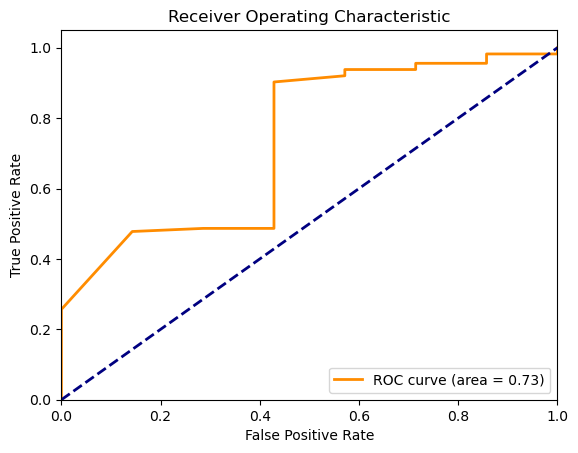

In [13]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [14]:
def plot_decision_boundaries(X, y, model):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(xgb.DMatrix(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.where(Z > 0.5, 1, 0).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary")

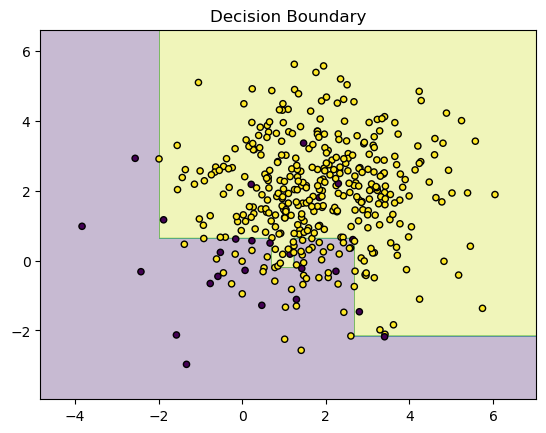

In [15]:
# Plot decision boundary
plot_decision_boundaries(X, y, bst)